# Part 1: Getting started

In [1]:
from tensorflow.keras.utils  import to_categorical

from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder, StandardScaler


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['PATH'] = '/tools/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0

tf.random.set_seed(seed)
np.random.seed    (seed)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mufwlcow because the default path (/home/gabri-bot/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Folders

In [3]:
USER_PATH    = os.getcwd()
DATA_PATH    = USER_PATH + "/Data/"
MODEL_PATH   = USER_PATH + "/Models/"
PROJECT_PATH = USER_PATH + "/HLS_projects/"

## Fetch the jet tagging dataset from Open ML

In [3]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [4]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [7]:
np.save(DATA_PATH + 'X_train_val.npy', X_train_val)
np.save(DATA_PATH + 'X_test.npy'     , X_test     )
np.save(DATA_PATH + 'y_train_val.npy', y_train_val)
np.save(DATA_PATH + 'y_test.npy'     , y_test     )
np.save(DATA_PATH + 'classes.npy'    , le.classes_)

In [4]:
X_train_val = np.load(DATA_PATH + 'X_train_val.npy')
X_test      = np.load(DATA_PATH + 'X_test.npy'     )
y_train_val = np.load(DATA_PATH + 'y_train_val.npy')
y_test      = np.load(DATA_PATH + 'y_test.npy'     )
classes     = np.load(DATA_PATH + 'classes.npy', allow_pickle=True)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [5]:
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1

from utils.callbacks import all_callbacks

In [6]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(BatchNormalization(epsilon=1e-6, momentum=0.999, name='bn1'))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(BatchNormalization(epsilon=1e-6, momentum=0.999, name='bn2'))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(BatchNormalization(epsilon=1e-6, momentum=0.999, name='bn3'))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(BatchNormalization(epsilon=1e-6, momentum=0.999, name='bnout'))
model.add(Activation(activation='softmax', name='softmax'))

2021-09-08 19:05:39.259499: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-08 19:05:39.259707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libamdhip64.so
2021-09-08 19:05:39.295129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1738] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: Ellesmere [Radeon RX 470/480/570/570X/580/580X]     ROCm AMD GPU ISA: gfx803
coreClock: 1.411GHz coreCount: 36 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119.21GiB/s
2021-09-08 19:05:39.297555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library librocblas.so
2021-09-08 19:05:39.298675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libMIOpen.so
2021-09-08 19:05:39.307629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 64)                1088      
_________________________________________________________________
relu1 (Activation)           (None, 64)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                2080      
_________________________________________________________________
relu2 (Activation)           (None, 32)                0         
_________________________________________________________________
fc3 (Dense)                  (None, 32)                1056      
_________________________________________________________________
relu3 (Activation)           (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 5)                 1

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [7]:
train = False

if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              verbose    = False,
                              outputDir = MODEL_PATH + 'Keras_only')
    with tf.device("/cpu:0"):
    #with tf.device("/gpu:0"):
        model.fit(X_train_val, y_train_val, batch_size=1024,
                  epochs=100, validation_split=0.25, shuffle=True,
                  verbose=0,
                  callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7652710843373494


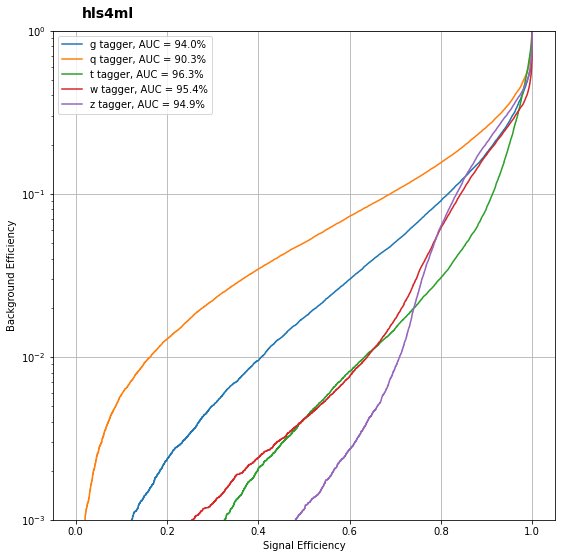

In [9]:
from utils import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
 
with tf.device('/cpu:0'):
    y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, classes)

# Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

## Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [10]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

#config['Backend'] = 'vivado_accelerator' 

config['Model'] = {}
config['Model']['ReuseFactor'] = 64
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'

config['LayerName']['fc1']['ReuseFactor'] = 8
config['LayerName']['fc2']['ReuseFactor'] = 32
config['LayerName']['fc3']['ReuseFactor'] = 16
config['LayerName']['output']['ReuseFactor'] = 16

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,6>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
config['LayerName']['softmax']['Strategy'] = 'Stable'

cfg = hls4ml.converters.create_backend_config(fpga_part='xc7z020clg400-1')
cfg['HLSConfig'] = config
#cfg['IOType']= 'io_stream'
cfg['Backend'] = 'Pynq'
cfg['Interface'] = 's_axilite' # or 'm_axi'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Keras_only/hls4ml_PYNQ_prj'

print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/HLS_projects/Keras_only/hls4ml_PYNQ_prj
ProjectName:         myproject
XilinxPart:          xc7z020clg400-1
ClockPeriod:         5
Backend:             Pynq
IOType:              io_parallel
HLSConfig
  Model
    ReuseFactor:     64
    Strategy:        Resource
    Precision:       ap_fixed<16,6>
  LayerName
    fc1_input
      Pr

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

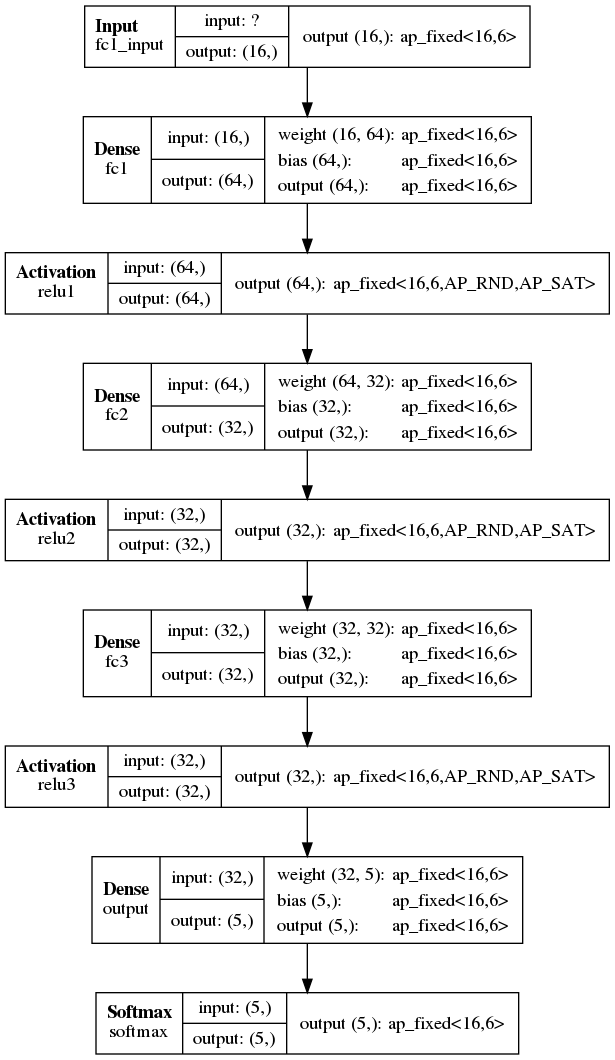

In [11]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [12]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


In [19]:
np.save(MODEL_PATH + 'Keras_only/HLS_data/y_hls.npy', y_hls)

## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7652710843373494
hls4ml Accuracy: 0.7649096385542169


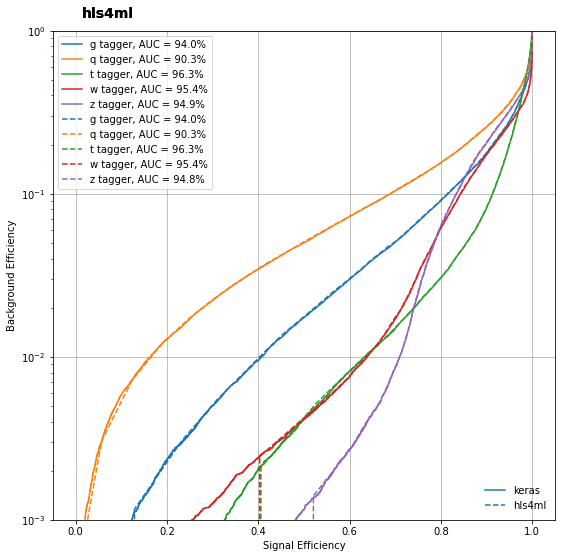

In [14]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [15]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'gabri-bot' on host 'gabribot-X570-AORUS-ELITE' (Linux_x86_64 version 5.4.0-050400-generic) on Wed Sep 08 19:07:46 CEST 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/HLS_projects/Keras_only/hls4ml_PYNQ_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/HLS_projects/Keras_only/hls4ml_PYNQ_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.

{'EstimatedClockPeriod': '4.039',
 'BestLatency': '139',
 'WorstLatency': '143',
 'IntervalMin': '140',
 'IntervalMax': '144',
 'BRAM_18K': '128',
 'DSP48E': '271',
 'FF': '33198',
 'LUT': '54114',
 'URAM': '0',
 'AvailableBRAM_18K': '280',
 'AvailableDSP48E': '220',
 'AvailableFF': '106400',
 'AvailableLUT': '53200',
 'AvailableURAM': '0'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [17]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Keras_only/hls4ml_PYNQ_prj/')

Found 1 solution(s) in /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/HLS_projects/Keras_only/hls4ml_PYNQ_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Wed Sep  8 19:09:04 2021

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.039 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    m